In [1]:
## Ues For intal Processor 
# !pip install -r requirements.txt
## Use requirements_silicon.txt for silicon Processor (M1,M2,M3 ,ect..)
# !pip install -r requirements_silicon.txt

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, Model,models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
# from tensorflow.keras.metrics import Metric, MeanIoU
from collections import Counter
import rasterio
import albumentations as A
from tensorflow.keras.applications import ResNet50

In [3]:
# ----------------------- DATA UTILITY FUNCTIONS ----------------------- #

def load_paths(file_path):
    """Load paths from a text file and return as a list."""
    with open(file_path, "r") as f:
        # print(f"Processing: {[os.path.abspath(line.strip()) for line in f.readlines()]}")
        return [os.path.abspath(line.strip()) for line in f.readlines()]


## 🎨 Class and Color Mappings

Supports full and merged class mappings via dictionaries:
- `class_mapping`, `color_mapping`
- `class_mapping_merged`, `color_mapping_merged`
- `merge_map` — for reducing number of classes

---

In [4]:


# ---------------------- CLASS MAPPINGS ---------------------- #
class_mapping = {
    1: 'Marine Debris',
    2: 'Dense Sargassum',
    3: 'Sparse Sargassum',
    4: 'Natural Organic Material',
    5: 'Ship',
    6: 'Clouds',
    7: 'Marine Water',
    8: 'Sediment-Laden Water',
    9: 'Foam',
    10: 'Turbid Water',
    11: 'Shallow Water',
    12: 'Waves',
    13: 'Cloud Shadows',
    14: 'Wakes',
    15: 'Mixed Water',
    0:'Unknown Class'
}
color_mapping = {
    1: (255, 0, 0),      # Marine Debris - Red
    2: (0, 128, 0),      # Dense Sargassum - Green
    3: (255, 255, 224),  # Foam - Light Yellow 
    4: (139, 69, 19),    # Natural Organic Material - Brown
    5: (128, 128, 128),  # Ship - Gray (Neutral and clear)
    6: (255, 255, 255),  # Clouds - White
    7: (0, 0, 255),      # Marine Water - Blue
    8: (210, 180, 140),  # Sediment-Laden Water - Tan
    9: (144, 238, 144),  # Sparse Sargassum - Light Green
    10: (64, 224, 208),  # Turbid Water - Turquoise
    11: (176, 224, 230), # Shallow Water - Powder Blue
    12: (0, 191, 255),   # Waves - Deep Sky Blue
    13: (105, 105, 105), # Cloud Shadows - Dim Gray
    14: (220, 220, 220), # Wakes - Gainsboro
    15: (70, 130, 180) , # Mixed Water - Steel Blue
    0: (211, 211, 211)  # Unknown background - Light Gray (Soft, neutral tone for unknown areas)
}

confidence_mapping = {
    1: 'High',
    2: 'Moderate',
    3: 'Low',
    0:'background',
}

# Mapping from original class IDs to new merged class IDs
merge_map = {
    0: 0,   # Unknown
    1: 1,   # Marine Debris
    2: 2,   # Sargassum
    3: 2,   # Sargassum
    4: 3,   # Organic Material
    5: 4,   # Ship
    6: 5,   # Clouds
    7: 6,   # Water
    8: 7,   # Sediment-laden water
    9: 3,   # Foam → Organic
    10: 6,  # Turbid water → Water
    11: 6,  # Shallow water → Water
    12: 6,  # Waves → Water
    13: 5,  # Cloud Shadows → Clouds
    14: 6,  # Wakes → Water
    15: 6   # Mixed Water → Water
}
merge_map_binary = {
    0: 0,   # Unknown
    1: 1,   # Marine Debris
}

class_mapping_merged = {
    0: "Unknown",
    1: "Marine Debris",
    2: "Sargassum",
    3: "Organic Material",
    4: "Ship",
    5: "Clouds",
    6: "Water",
    7: "Sediment-laden Water"
}

color_mapping_merged = {
    0: (211, 211, 211),  # Light gray
    1: (255, 0, 0),      # Red
    2: (0, 128, 0),      # Green
    3: (160, 82, 45),    # SaddleBrown (Organic)
    4: (128, 128, 128),  # Gray
    5: (255, 255, 255),  # White
    6: (0, 0, 255),      # Blue
    7: (210, 180, 140)   # Tan
}

In [5]:
# ---------------------- DATA PIPELINE ---------------------- #

class DataPipeline:
    """
    A preprocessing pipeline for satellite image data, including augmentation and band normalization.

    Parameters:
    -----------
    img_size : tuple
        Target size (height, width) for input images.
    num_classes : int
        Number of classes for the segmentation/masking task.
    rare_classes : list or None
        List of class indices that are considered rare (optional).
    normalization_method : str
        Normalization strategy to apply on each band. Options:
            - 'percentile': Scales data between 0–1 using the 2nd and 98th percentiles.
            - 'robust': Normalizes using median and IQR, then clips to [-1, 1].
            - 'minmax': Normalizes using exact min and max values per band.
    """

    def __init__(self, img_size,num_bands, num_classes, rare_classes=None, normalization_method='robust',use_merged_labels=False, merge_map=None):
        self.img_size = img_size
        self.num_bands=num_bands
        self.num_classes = num_classes
        self.rare_classes = rare_classes
        self.normalization_method = normalization_method
        self.use_merged_labels = use_merged_labels
        self.merge_map = merge_map or {}

         
        # Define common augmentations using Albumentations 
        self.augmentation_pipeline = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.RandomGamma(p=0.3),
            A.GaussNoise(p=0.2),
        ], additional_targets={'mask': 'mask'})
    
    def normalize_band(self, band):
        """
        Normalize a single image band using the configured method.
        - 'percentile'
        - 'robust'
        - 'minmax'
        
        Parameters:
        -----------
        band : np.ndarray
            A single spectral band (2D array).

        Returns:
        --------
        normalized_band : np.ndarray
            The normalized band.
        """
        if self.normalization_method == 'percentile':
            min_val, max_val = np.percentile(band, (2, 98))
            normalized_band = np.clip((band - min_val) / (max_val - min_val + 1e-6), 0, 1)

        elif self.normalization_method == 'robust':
            median = np.median(band)
            q1, q3 = np.percentile(band, [25, 75])
            iqr = q3 - q1
            normalized_band = (band - median) / (iqr + 1e-6)
            normalized_band = np.clip(normalized_band, -1, 1)

        elif self.normalization_method == 'minmax':
            min_val, max_val = np.min(band), np.max(band)
            normalized_band = (band - min_val) / (max_val - min_val + 1e-6)

        else:
            raise ValueError("Unsupported normalization method. Choose 'percentile', 'robust', or 'minmax'.")

        return normalized_band.astype(np.float32)

    def load_image(self, image_path):
        """
        Load and normalize multiple bands and compute vegetation/water indices.

        Parameters:
        -----------
        image_path : str
            Path to the satellite image file.

        Returns:
        --------
        image : np.ndarray
            Multi-band image of shape (H, W, 9).
        """
        with rasterio.open(image_path) as src:
            blue = self.normalize_band(src.read(2))
            green = self.normalize_band(src.read(3))
            red = self.normalize_band(src.read(4))
            nir = self.normalize_band(src.read(8))
            swir1 = self.normalize_band(src.read(11))
            
             # Calculate selected indices
            ndvi = self.normalize_band((nir - red) / (nir + red + 1e-6))
            ndwi = self.normalize_band((green - swir1) / (green + swir1 + 1e-6))
            fdi = self.normalize_band(nir / (red + swir1 + 1e-6))
            pfdi = self.normalize_band((swir1 - nir) / (swir1 + nir + red + 1e-6))
            
            # Stack bands and indices into one image
            image=np.stack([red, green, blue,nir,swir1,ndvi,ndwi,fdi,pfdi], axis=-1)
            # image=np.stack([blue,nir,swir1], axis=-1)
            if self.num_bands != image.shape[2] :
                print(f'The number of the banes images({image.shape[2]}) not Matchthe number of the channel input({self.num_bands})')
                
        return image.astype(np.float32)
            


    def load_mask(self, mask_path):
        """
        Load and remap a raw mask to a fixed label range [0, 14], background = 15.

        Parameters:
        -----------
        mask_path : str
            Path to mask file.

        Returns:
        --------
        processed_mask : np.ndarray
            Processed mask with shape (H, W), dtype uint8.
        """
        with rasterio.open(mask_path) as src:
            raw_mask = src.read(1).astype(np.uint8)
            # unique_classes = np.unique(raw_mask)
            # print("Unique classes in raw mask:", unique_classes)

        # processed_mask = np.where((raw_mask >= 1) & (raw_mask <= 15), raw_mask - 1, 15)    # background = 15
        # unique_processed_classes = np.unique(processed_mask)
        # print("Unique classes in processed mask:", unique_processed_classes)
        if self.use_merged_labels:
            remapped = np.copy(raw_mask)
            for old_id, new_id in self.merge_map.items():
                remapped[raw_mask == old_id] = new_id
            return remapped
        else:
            return raw_mask
    
    def load_confidence(self, conf_path):
        """
        Load and process confidence map for training masking or quality control.

        Parameters:
        -----------
        conf_path : str
            Path to confidence map.

        Returns:
        --------
        processed_mask : np.ndarray
            Confidence labels remapped similarly to masks.
        """
        with rasterio.open(conf_path) as src:
            conf = src.read(1).astype(np.uint8)
            # unique_classes_conf = np.unique(conf)
            # print("Unique classes in Conf:", unique_classes_conf)
            
            # processed_mask = np.where((conf >= 1) & (conf <= 3), conf - 1, 15)
            # unique_processed_classes = np.unique(processed_mask)
            # print("Unique classes in Conf_processed:", unique_processed_classes)
            
        return conf
    
    def has_rare_class(self, mask):
        """
        Check if the given mask contains any rare class IDs.

        Parameters:
        -----------
        mask : np.ndarray
            Ground truth mask.

        Returns:
        --------
        bool
            True if rare class is found, else False.
        """
        return self.rare_classes and np.any(np.isin(mask, self.rare_classes))


    def apply_augmentation(self, image, mask):
        """
        Apply random augmentations to image and mask.

        Parameters:
        -----------
        image : np.ndarray
        mask : np.ndarray

        Returns:
        --------
        tuple : (augmented_image, augmented_mask)
        """
        augmented = self.augmentation_pipeline(image=image, mask=mask)
        return augmented['image'], augmented['mask']
    
    
    def preprocess_pair(self, image_path, mask_path, augment=False, augment_rare_only=False):
        """
        Load, normalize, and (optionally) augment a single image-mask pair.

        Parameters:
        -----------
        image_path : str or bytes
        mask_path : str or bytes
        augment : bool
            Whether to apply augmentation.
        augment_rare_only : bool
            Apply augmentation only if rare class exists.

        Returns:
        --------
        image : np.ndarray
            Preprocessed image with 9 channels.
        mask_one_hot : np.ndarray
            One-hot encoded mask of shape (H, W, num_classes).
        """
        if isinstance(image_path, bytes): image_path = image_path.decode("utf-8")
        if isinstance(mask_path, bytes): mask_path = mask_path.decode("utf-8")
        
        image = self.load_image(image_path)
        mask = self.load_mask(mask_path)
        
        # unique_classes = np.unique(mask)
        # print("Unique values in mask:", unique_classes)

        if augment:
            if augment_rare_only:
                if not augment_rare_only or self.rare_classes and np.any(np.isin(mask, self.rare_classes)):
                    image, mask = self.apply_augmentation(image, mask)

        mask_one_hot = np.eye(self.num_classes, dtype=np.float32)[mask]
        # print("Mask shape after one-hot encoding:", mask_one_hot.shape)
        return image, mask_one_hot
    
    
    def get_tf_dataset(self, image_paths, mask_paths, batch_size, augment=False, augment_rare_only=False):
        """
        Create a TensorFlow dataset from image and mask paths.

        Parameters:
        -----------
        image_paths : list
        mask_paths : list
        batch_size : int
        augment : bool
        augment_rare_only : bool

        Returns:
        --------
        tf.data.Dataset
            A preprocessed, batched, and prefetched dataset.
        """
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

        def _load_data(img_path, mask_path):
            img, mask = tf.numpy_function(
                self.preprocess_pair,
                [img_path, mask_path, augment, augment_rare_only],
                [tf.float32, tf.float32]
            )
            img.set_shape((*self.img_size, self.num_bands))        # Corrected  9 bands
            mask.set_shape((*self.img_size, self.num_classes))   # One-hot encoded mask
            return img, mask

        return dataset.map(_load_data, num_parallel_calls=tf.data.AUTOTUNE)\
                      .batch(batch_size)\
                      .prefetch(tf.data.AUTOTUNE)


    def summarize_dataset(self, dataset):
        """
        Print dataset summary with class pixel distribution.

        Parameters:
        -----------
        dataset : tf.data.Dataset
            Dataset to summarize.
        """
        total_images = 0
        class_counts = np.zeros(self.num_classes)

        for imgs, masks in dataset:
            total_images += imgs.shape[0]
            masks = masks.numpy().argmax(-1)
            unique, counts = np.unique(masks, return_counts=True)
            class_counts[unique] += counts

        print(f"\n📊 Dataset Summary:")
        print(f"- Total images: {total_images}")
        for idx, count in enumerate(class_counts):
            print(f"  - Class {idx:2d}: {int(count)} pixels")
            

In [6]:

# ---------------------- CONFIGURATION ---------------------- #
IMG_SIZE = (256, 256)
NUM_BANDS=9
NUM_CLASSES = len(set(merge_map_binary.values()))  # Use < class_mapping.values() >  for haveing 16 classes or  < merge_map.values() >  for haveing 8 classes
BATCH_SIZE = 32
EPOCHS = 120

# ----------------------- LOAD AND PREPROCESS DATA ----------------------- #

# Initialize pipeline
pipeline = DataPipeline(
    img_size=IMG_SIZE,
    num_bands=NUM_BANDS,
    num_classes=NUM_CLASSES, # Use < class_mapping.values() >  for haveing 16 classes or  < merge_map.values() >  for haveing XX classes
    rare_classes=[1], # the maximum number should be the NUM_CLASSES-1
    normalization_method='minmax', # Normalize a single image band using the configured method - 'percentile' - 'robust' - 'minmax'
    use_merged_labels=True, # make this one True if you Would like to customize the classes number to be 8 And you should to pass the merge map Dictionary Otherwise, make false
    merge_map=merge_map_binary
    
)

# Load paths from your original split files
train_imgs = load_paths("./data/splits/train_X.txt")
train_masks = load_paths("./data/splits/train_masks.txt")
val_imgs = load_paths("./data/splits/val_X.txt")
val_masks = load_paths("./data/splits/val_masks.txt")
test_imgs = load_paths("./data/splits/test_X.txt")
test_masks = load_paths("./data/splits/test_masks.txt")

# Create datasets
train_dataset = pipeline.get_tf_dataset(
    train_imgs, train_masks, batch_size=32, augment=True, augment_rare_only=True
)
# Create datasets
val_dataset = pipeline.get_tf_dataset(
    val_imgs, val_masks, batch_size=32, augment=False
)
# Create datasets
test_dataset = pipeline.get_tf_dataset(
    test_imgs, test_masks, batch_size=32, augment=False
)

# Summarize dataset
pipeline.summarize_dataset(train_dataset)

# ----------------------- VALIDATE ONE BATCH ----------------------- #
for img, mask in train_dataset.take(1):
    print("✅ Image shape:", img.shape)
    print("✅ Mask shape:", mask.shape)
    print("✅ Mask unique values:", np.unique(mask.numpy().argmax(axis=-1)))



2025-05-12 23:12:20.652022: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-05-12 23:12:20.652046: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-12 23:12:20.652049: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-05-12 23:12:20.652082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-12 23:12:20.652095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



📊 Dataset Summary:
- Total images: 1221
  - Class  0: 79927514 pixels
  - Class  1: 91942 pixels
✅ Image shape: (32, 256, 256, 9)
✅ Mask shape: (32, 256, 256, 2)
✅ Mask unique values: [0 1]


2025-05-12 23:12:31.385564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step
Predicted mask shape: (32, 256, 256, 2)
Predicted mask shape: (32, 256, 256, 2)
Unique classes in predicted mask: [0 1]
Unique classes in ground truth mask: [0 1]


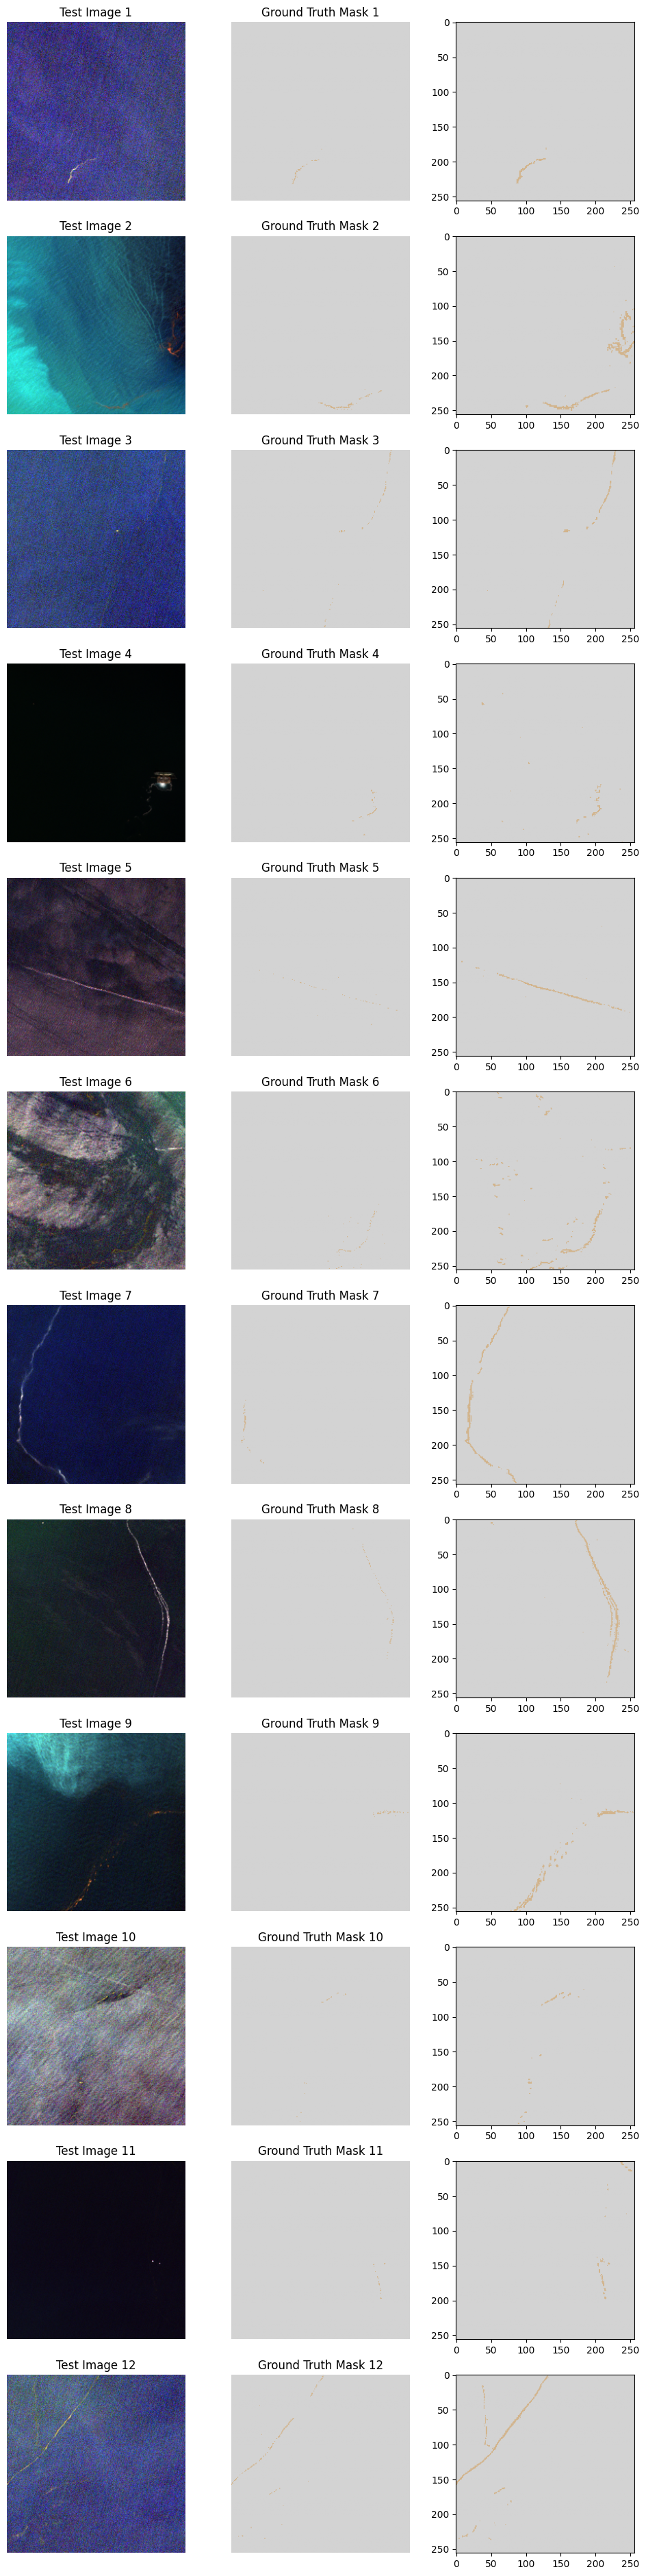

In [7]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "#d3d3d3", "#ff0000", "#008000", "#a0522d", "#808080", 
    "#ffffff", "#0000ff", "#d2b48c"  # color_mapping_merged
])

# Load the trained model
model_loaded = load_model("./models/attention_unet_plastic_segmentation_model_2_binary.keras", compile=False)

# Get a batch of test images and ground truth masks
sample_img, sample_mask = next(iter(test_dataset)) # Use test_dataset instead of train_dataset
 
# Get model predictions
pred_mask = model_loaded.predict(sample_img)

# Print the shape of the predicted mask
print("Predicted mask shape:", pred_mask.shape)
print("Predicted mask shape:", sample_mask.shape)  # Should be (batch_size, height, width, num_classes)

# Get unique classes in the predicted mask and ground truth mask
unique_classes_pred = np.unique(np.argmax(pred_mask, axis=-1))
unique_classes_true = np.unique(np.argmax(sample_mask, axis=-1))

print("Unique classes in predicted mask:", unique_classes_pred)
print("Unique classes in ground truth mask:", unique_classes_true)

# Number of images to visualize
num_images_to_show = min(12, sample_img.shape[0])  # Show up to 5 images


# Plot test image, ground truth mask, and predicted mask
fig, axes = plt.subplots(num_images_to_show, 3, figsize=(12, 4 * num_images_to_show))

for i in range(num_images_to_show):
    ax1, ax2, ax3 = axes[i]
    
      # Display the test image as RGB with custom channel indices
    rgb_image = np.stack([
        sample_img[i, :, :, 0],  # Red channel (index 1)
        sample_img[i, :, :, 1],  # Green channel (index 2)
        sample_img[i, :, :, 2]   # Blue channel (index 3)
    ], axis=-1)    
    # Display the test image
    ax1.imshow(rgb_image)
    ax1.set_title(f"Test Image {i+1}")
    ax1.axis('off')

    # Display the ground truth mask
    ax2.imshow(np.argmax(sample_mask[i], axis=-1), cmap=cmap)
    ax2.set_title(f"Ground Truth Mask {i+1}")
    ax2.axis('off')

    # Display the predicted mask
    ax3.imshow(np.argmax(pred_mask[i], axis=-1), cmap=cmap)


📌 Training Summary (55 Epochs)
## 🟢 1. Loss:
Training Loss improved significantly from 0.2141 at Epoch 1 to 0.0476 at Epoch 55.

Validation Loss also improved dramatically from 0.1739 at Epoch 1 to its best value of 0.01645 at Epoch 45, indicating the model is effectively learning and generalizing well.

## 🔵 2. IoU (Intersection over Union):
Training IoU significantly increased from 0.4691 (Epoch 1) to a high of around 0.9178 (Epoch 48), demonstrating strong performance on the training set.

Validation IoU remained consistently very high (above 0.97 throughout). This extremely high validation IoU likely indicates dominance by the background class due to severe class imbalance.

## 🟠 3. F1 Score (Most critical due to class imbalance):
Training F1 gradually improved from 0.3173 (Epoch 1) to approximately 0.4908 at Epoch 48, indicating moderate detection of the rare "Marine Debris" class.

Validation F1 improved from 0.4974 initially to a peak of 0.5568 at Epoch 46, showing modest but limited improvement in detecting the minority class